In [58]:
from datetime import datetime
import dask.array as da
import os
import time
import h5py
import glob
import numpy as np
import xarray as xr
import downscale as down

import pandas as pd
import geopandas as gpd
import scipy.stats as stats

from scipy.stats import weibull_min

import cartopy
import cartopy.feature as cf
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader

from matplotlib import patches
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.gridspec as gridspec

import warnings
warnings.filterwarnings('ignore')

## This code check the Weibull parameters for stations in CONUS

In [59]:
yy_s = 2007
yy_e = 2012

yy_num = yy_e - yy_s + 1
maxmiss = 80

print(f'Number of years : {yy_num}')
print(f'Maximum Nan data: {maxmiss}')

Number of years : 6
Maximum Nan data: 80


In [60]:
base_dir = os.path.join('/','home','arturo','github','downpy','data')

In [61]:
file_list = glob.glob(os.path.join(base_dir, 'data_noaa_hpd_gauges', 'daily_csv', '*.csv'))
file_list = sorted(file_list)
len_list = len(file_list)
print(f'NUmber of files: {len_list}')

list_names = []
for nn in range(len_list):
    tmp = file_list[nn].split('/')[-1].split('.')[0]
    list_names.append(tmp)

data_dir = os.path.join(base_dir, 'data_noaa_hpd_gauges', 'HOURLY_LOC_NYEARS.csv')
INFO = pd.read_csv(data_dir)

NUmber of files: 1928


In [62]:
lo_limit_min, lo_limit_max, la_limit_min, la_limit_max = -90, -80, 30, 35

In [63]:
lat_rain = []
lon_rain = []
id_rain = []
for nn in range(len(list_names)):
    TEST = INFO[INFO['ID']==list_names[nn]]
    lat_rain.append(TEST['LAT'].values[0])
    lon_rain.append(TEST['LON'].values[0])
    id_rain.append(TEST['ID'].values[0])

lat_rain = np.array(lat_rain)
lon_rain = np.array(lon_rain)
id_rain = np.array(id_rain)


lat_bnds = np.where((lat_rain>=la_limit_min)&(lat_rain<=la_limit_max))[0]

lat_rain = lat_rain[lat_bnds]
lon_rain = lon_rain[lat_bnds]
id_rain = id_rain[lat_bnds]

lon_bnds = np.where((lon_rain>=lo_limit_min)&(lon_rain<=lo_limit_max))[0]

lat_rain = lat_rain[lon_bnds]
lon_rain = lon_rain[lon_bnds]
id_rain = id_rain[lon_bnds]

In [64]:
NC_all = np.zeros([yy_num, len(id_rain)])
CY_all = np.zeros([yy_num, len(id_rain)])
Wd_all = np.zeros([yy_num, len(id_rain)])

for cid in range(len(id_rain)):#len(id_rain)

    input_dir = os.path.join(base_dir,'data_noaa_hpd_gauges','daily_csv',f'{id_rain[cid]}.csv')
    RAIN = pd.read_csv(input_dir)
    RAIN = RAIN[(RAIN['YEAR']>=yy_s)&(RAIN['YEAR']<=yy_e)]

    RAIN=RAIN.mask(RAIN==np.min(RAIN['PRCP'])).fillna(0)

    datetime_OBS = pd.to_datetime(RAIN['DATE'].values, format='%Y%m%d')
    RAIN['TIME'] = datetime_OBS

    TIME_REF = pd.date_range(start=f'{yy_s}-01-01', end=f'{yy_e}-12-31', freq='d')
    TIME_PD = pd.DataFrame({'TIME':TIME_REF})

    if len(RAIN['PRCP'].values) < len(TIME_REF):
        OBS_NEW = pd.merge(RAIN, TIME_PD, on='TIME', how='right')

    OBS_xr = xr.DataArray(OBS_NEW['PRCP'].values,  coords={'time':OBS_NEW['TIME'].values}, dims=('time'))
    NCW_OBS, YEARS_OBS = down.fit_yearly_weibull(OBS_xr, thresh=1, maxmiss=maxmiss)
    
    NC_all[:, cid] = NCW_OBS[:,0]
    CY_all[:, cid] = NCW_OBS[:,1]
    Wd_all[:, cid] = NCW_OBS[:,2]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


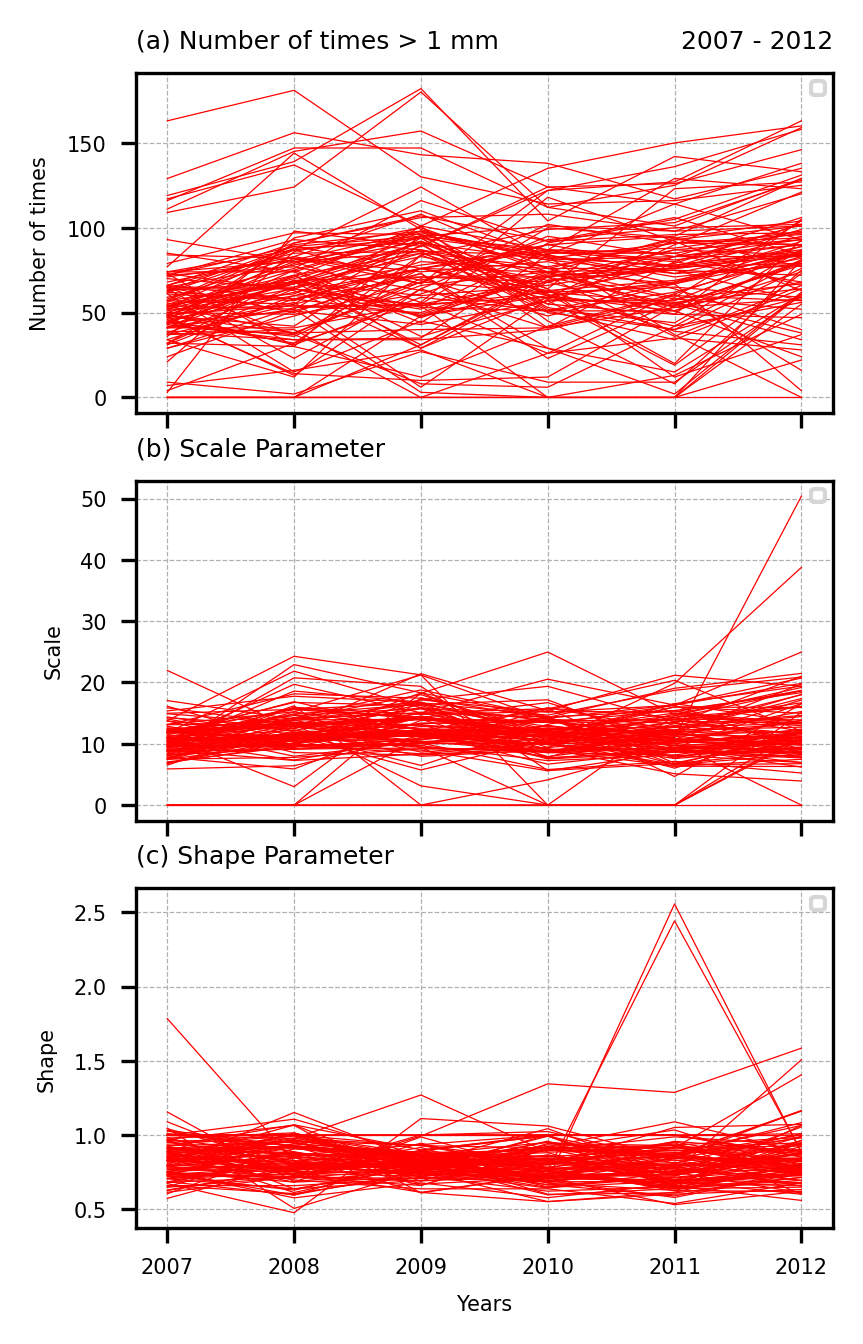

In [65]:
fig = plt.figure(figsize=(3,5),dpi=300)
gs = gridspec.GridSpec(3,1)

# =================================================================
ax1 = plt.subplot(gs[0, 0])
for nn in range(len(id_rain)):
    ax1.plot(YEARS_OBS, NC_all[:,nn], c='r', linewidth=0.3)
# ax1.plot(YEARS_IMERG, NCW_IMERG[:,0], c='b', label=f'IMERG daily')
# ax1.plot(downres['YEARS'], downres['NYd'], c='g', label=f'DOWN daily')
ax1.legend(fontsize=4)
ax1.grid(linestyle='--', linewidth=0.3)
ax1.set_title('(a) Number of times > 1 mm',loc='left',fontsize=6)
ax1.set_title(f'{yy_s} - {yy_e}',loc='right',fontsize=6)
ax1.set_ylabel('Number of times', fontsize=5)

ax1.xaxis.set_tick_params(labelsize=5)
ax1.yaxis.set_tick_params(labelsize=5)
ax1.set_xticklabels([])

# =================================================================
ax1 = plt.subplot(gs[1, 0])
for nn in range(len(id_rain)):
    ax1.plot(YEARS_OBS, CY_all[:,nn], c='r', linewidth=0.3)
# ax1.plot(YEARS_IMERG, NCW_IMERG[:,1], c='b', label=f'TRMM daily')
# ax1.plot(downres['YEARS'], downres['CYd'], c='g', label=f'DOWN daily')
ax1.legend(fontsize=4)
ax1.grid(linestyle='--', linewidth=0.3)
ax1.set_title('(b) Scale Parameter',loc='left',fontsize=6)
ax1.set_ylabel('Scale', fontsize=5)

ax1.xaxis.set_tick_params(labelsize=5)
ax1.yaxis.set_tick_params(labelsize=5)
ax1.set_xticklabels([])

# =================================================================
ax1 = plt.subplot(gs[2, 0])
for nn in range(len(id_rain)):
    ax1.plot(YEARS_OBS, Wd_all[:,nn], c='r', linewidth=0.3)
# ax1.plot(YEARS_IMERG, NCW_IMERG[:,2], c='b', label=f'TRMM daily')
# ax1.plot(downres['YEARS'], downres['WYd'], c='g', label=f'DOWN daily')
ax1.legend(fontsize=4)
ax1.grid(linestyle='--', linewidth=0.3)
ax1.set_title('(c) Shape Parameter',loc='left',fontsize=6)
ax1.set_ylabel('Shape', fontsize=5)
ax1.set_xlabel('Years', fontsize=5)

ax1.xaxis.set_tick_params(labelsize=5)
ax1.yaxis.set_tick_params(labelsize=5)

In [66]:
NCW_all[:,4]

array([55., 73., 29.,  2., 62.])

In [67]:
len(RAIN)

1806